# Linescan loading and display examples

In this notebook we will explore using the Open Data Cube to access linescan imagery.

In [1]:
%matplotlib inline
import sys
from matplotlib import pyplot as plt

from datacube import Datacube
from IPython.display import Image
from datacube.testutils.io import native_geobox


sys.path.append("../scripts")
from dea_plotting import rgb
from dea_plotting import xr_animation

In [2]:
dc = Datacube(app="Linescan examples")

## Using datacube metadata to load linescan data in native resolution

Linescans images have been collected in a variety of resolutions. To ensure we retrieve linescan images using their native resolution and projection we must first query for the metadata for the images we want to load, then use that data to load it. In this instance, we will create a trivial function to find a single linescan dataset before we load it in it's native resolution

In [3]:
def load_linescan_native(**qargs):
    """
    Simple example function to load linescan data from datacube using it's native resolution and projection
    """

    qargs['product'] = 'linescan'
    
    datasets = dc.find_datasets(**qargs)
    num_ds = len(datasets)
    if (num_ds>1):
        print("This fuction only returns a single linescan image, your query found: "+ str(num_ds))
        print("Consider refining your query using one of the the following criteria")
        for dataset in datasets:
            print("For linescan dataset: "+dataset.metadata_doc['label'])
            print("id: " + dataset.metadata_doc['id'])
            print("lat|lon: ")
            print(dataset.metadata_doc['extent'])
            print("time: " + dataset.metadata_doc['properties']['datetime'])
        return None
    elif (num_ds == 0):
        return None
    dataset = datasets[0]
    
    qargs['output_crs'] = dataset.metadata_doc['crs']
    qargs['id'] = dataset.metadata_doc['id']
    ng = native_geobox(dataset)
    
    qargs['resolution'] = ng.resolution
    qargs['align'] = ng.alignment
    
    return dc.load(**qargs)

In [4]:
# an arbirary area of interest
aoi = {
    "time" : "2019-01-25"
}
data = load_linescan_native(time = aoi["time"])

This fuction only returns a single linescan image, your query found: 16
Consider refining your query using one of the the following criteria
For linescan dataset: ABERFELDY_WEST_200_P1_201901260955_MGA94_55
id: 7444bc82-3723-5527-b374-ccc9c89ba48d
lat|lon: 
{'lat': {'end': -37.64381822957389, 'begin': -37.71456562161399}, 'lon': {'end': 146.29125050278884, 'begin': 146.1578804242253}}
time: 2019-01-25T22:55:00Z
For linescan dataset: NUNNETT_173_P1_201901251120_MGA94_55
id: 1913b141-0955-5b3e-b517-9e04d0ad17f8
lat|lon: 
{'lat': {'end': -37.20453983632997, 'begin': -37.31710981730293}, 'lon': {'end': 148.13366185599034, 'begin': 147.92464165805703}}
time: 2019-01-25T00:20:00Z
For linescan dataset: NUNNETT_174_P1_201901251128_MGA94_55
id: 1c72ad17-c2d0-55a3-9976-d88de5056651
lat|lon: 
{'lat': {'end': -37.18373091749279, 'begin': -37.323559512910165}, 'lon': {'end': 148.13557836808423, 'begin': 147.91000272039585}}
time: 2019-01-25T00:28:00Z
For linescan dataset: NUNNETT_175_P1_20190125113

In [5]:
# using the information from above, we can use their timestamps to differientiate them
# we could also use id or a spatial query
linescan1 = load_linescan_native(time = "2019-01-25T22:55:00Z")
linescan2 = load_linescan_native(time = "2019-01-25T00:20:00Z")

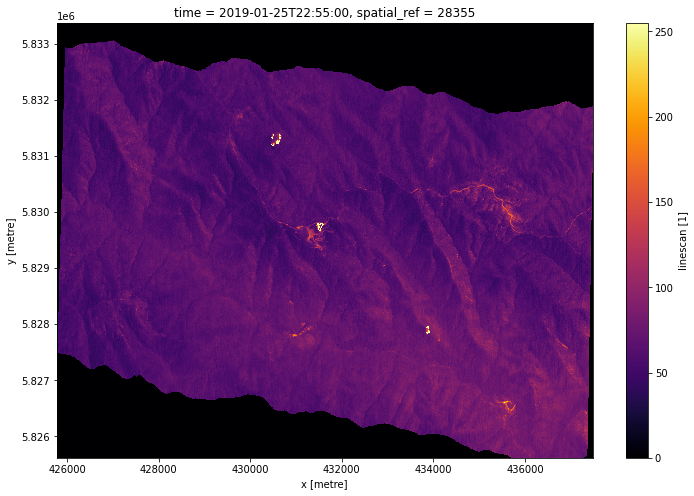

In [6]:
linescan1['linescan'].squeeze().plot.imshow(cmap='inferno', robust=False, size=8)

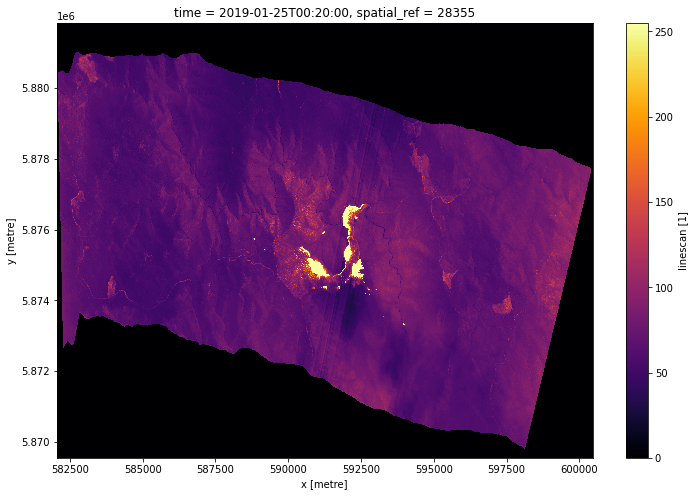

In [7]:
linescan2['linescan'].squeeze().plot.imshow(cmap='inferno', robust=False, size=8)

## Using datacube.load() to load linescan data with arbitrary resolution

Alternatively, we may want to load multiple, heterogenous linescan images at once.

In [8]:
 def load_matching_acquisition(product, linescan_doc, lat = None, lon = None, resolution = (-10,10), measurements=['nbar_red','nbar_blue','nbar_green']):
    extent = linescan_doc['extent']
    datetime = linescan_doc['properties']['datetime']
    
    if not lat:
        lat = (extent['lat']['begin'],extent['lat']['end'])
    if not lon:
        lon = (extent['lon']['begin'],extent['lon']['end'])
    
    output_crs = linescan_doc['grid_spatial']['projection']['spatial_reference']
    
    return dc.load(product=product, lon=lon, lat=lat, time=datetime[:10], resolution=resolution, measurements=measurements, output_crs = output_crs,
                  group_by="solar_day")


In this example, we will find all the Linescan and Sentinel-2A imagery for 25-01-2019 Nunnet fire. We find the smallest common overlapping bounding box and the lowest resolution

In [9]:
target_ids = []

# initialize lat and lon arrays to maximum possible 
lat = [-90,90]
lon = [-180,180]
# initialize resolution to arbitrarily small number
resolution = [-0,0]

time='2019-01-25'

# find all linescan images for a given date
ds = dc.find_datasets(product='linescan',time=time)

# unfortunately find_datasets does not sort, as we will use these datasets to generate a set of sequential images,
# we will sort by datetime manually
ds.sort(key=lambda x: x.metadata_doc['properties']['datetime'])

# now we iterate all datasets to first filter by label, then find the smallest common overlapping bounding box
# and lowest resolution
# note there isn't really a good way to specify a common align(ment), so this time it is ignored
for dataset in ds:
    linescan_doc = dataset.metadata_doc
    # unfortunately we cannot search by dataset label, so we will have to filter manually
    if linescan_doc['label'].startswith('NUNNET'):
        extent = linescan_doc['extent']
        
        if extent['lat']['begin'] > lat[0]:
            lat[0] = extent['lat']['begin']
        if extent['lat']['end'] < lat[1]:
            lat[1] = extent['lat']['end']
        
        if extent['lon']['begin'] > lon[0]:
            lon[0] = extent['lon']['begin']
        if extent['lon']['end'] < lon[1]:
            lon[1] = extent['lon']['end']
            
        ng = native_geobox(dataset)

        if resolution[0] > ng.resolution[0]:
            resolution[0] = ng.resolution[0]
        if resolution[1] < ng.resolution[1]:
            resolution[1] = ng.resolution[1]

        target_ids.append(dataset.metadata_doc['id'])
lat = tuple(lat)
lon = tuple(lon)
resolution = tuple(resolution)

# visualise using a false colour band combination
measurements = ['nbar_B12', 'nbar_B8A', 'nbar_B05']

s_2_data = load_matching_acquisition(
    product='ga_s2a_ard_nbar_granule', 
    linescan_doc=ds[0].metadata_doc, 
    measurements=measurements, lat=lat, lon=lon)


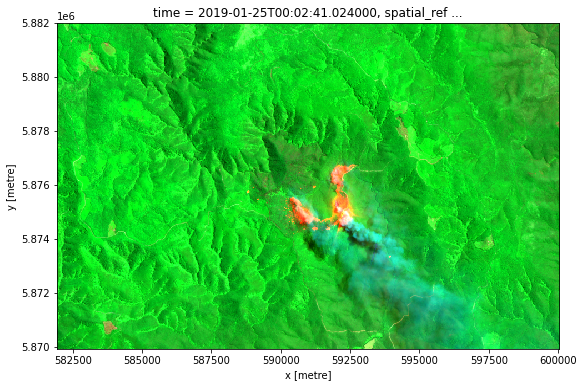

In [10]:
rgb(s_2_data.squeeze(),bands=measurements)

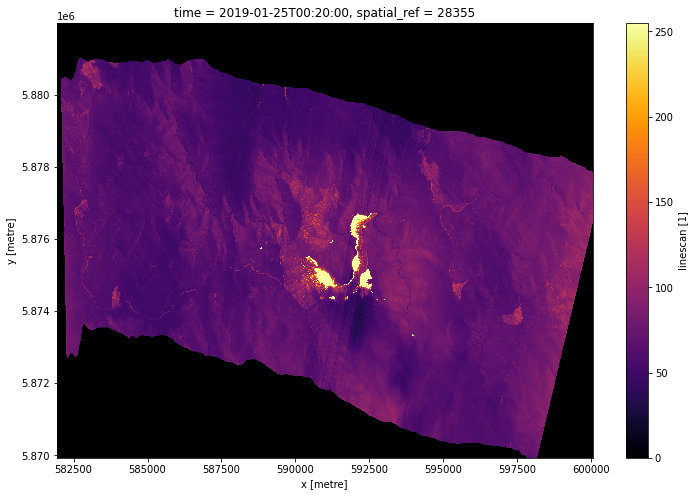

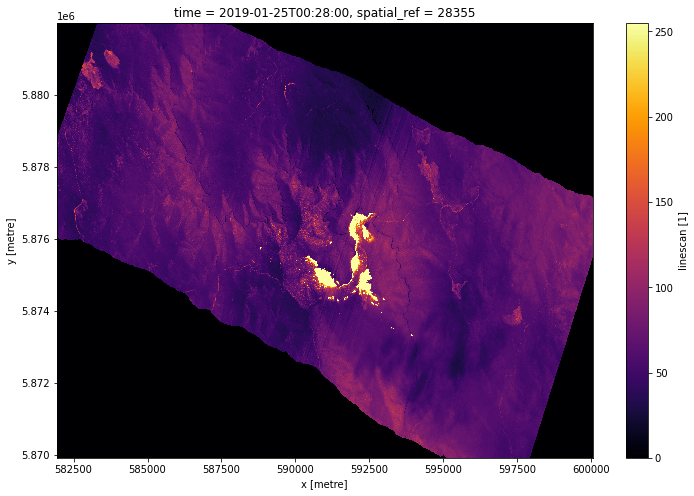

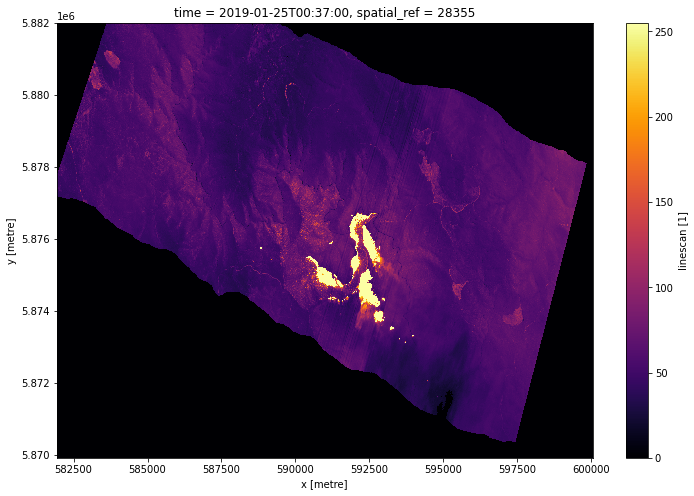

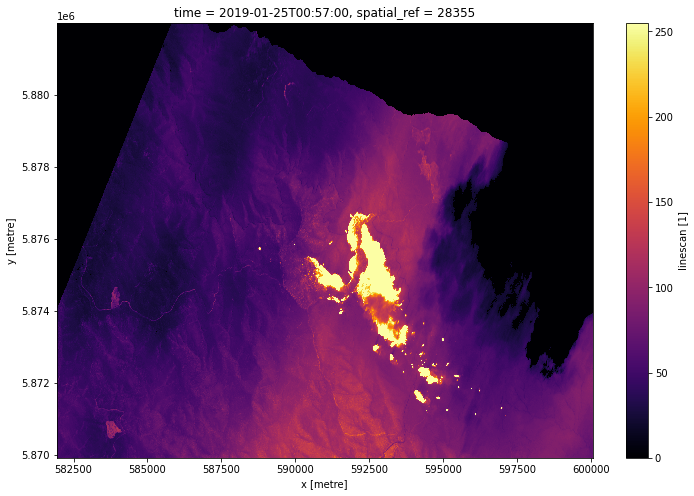

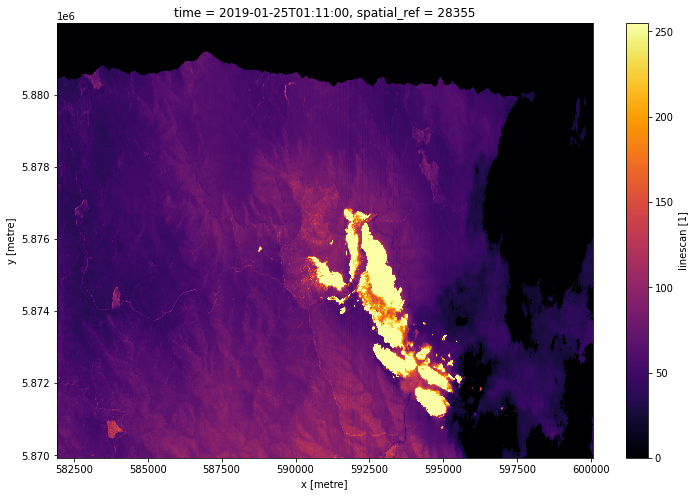

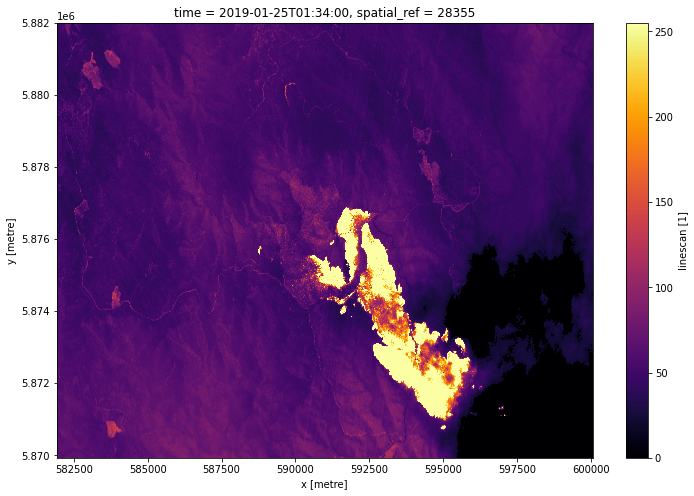

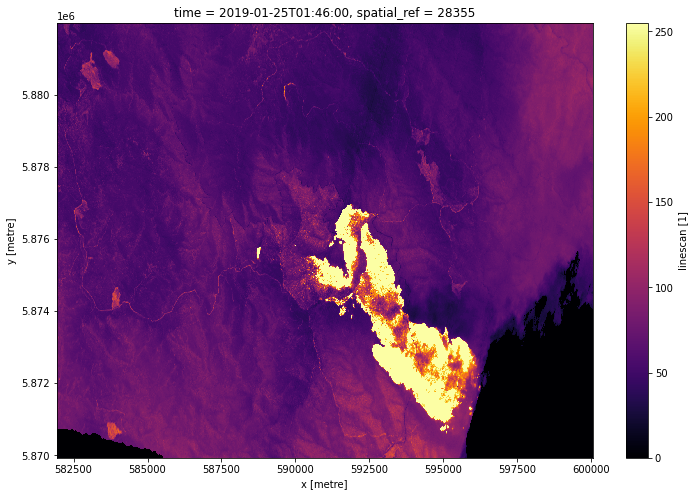

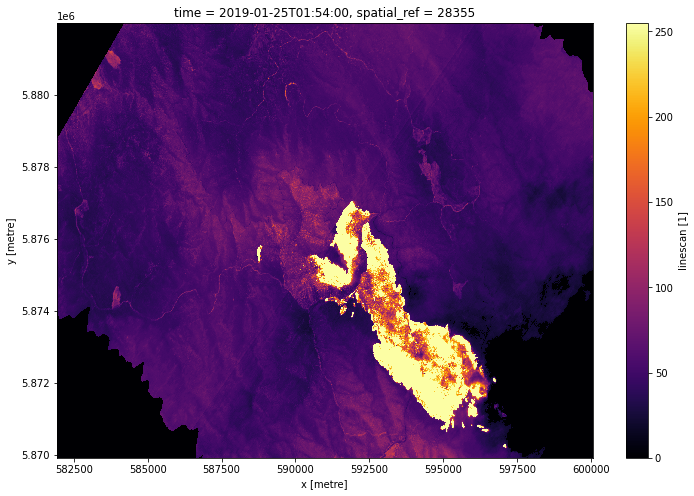

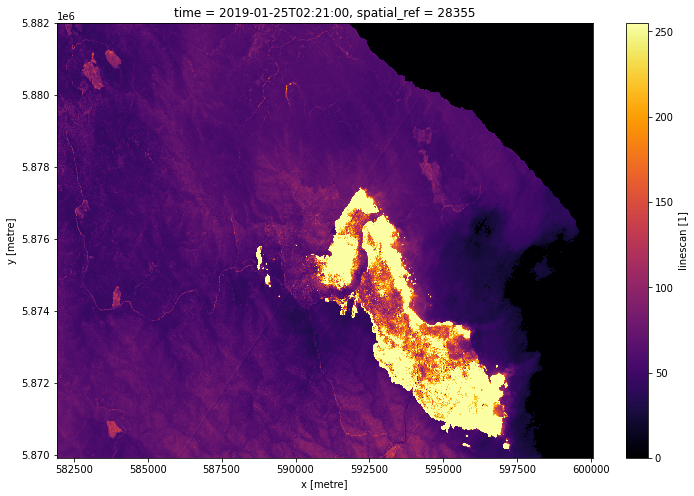

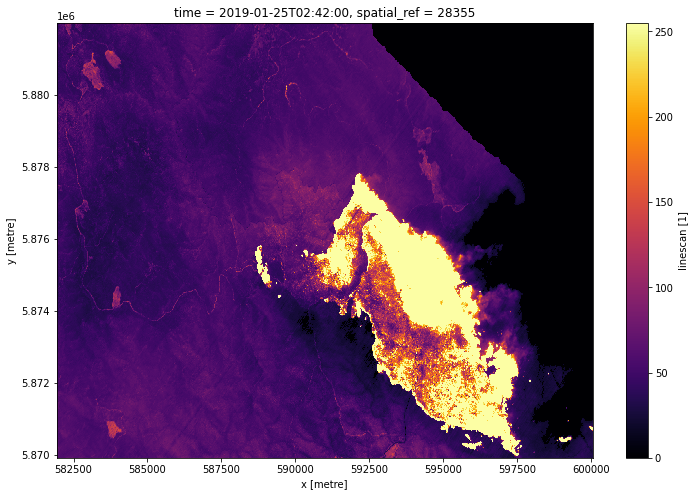

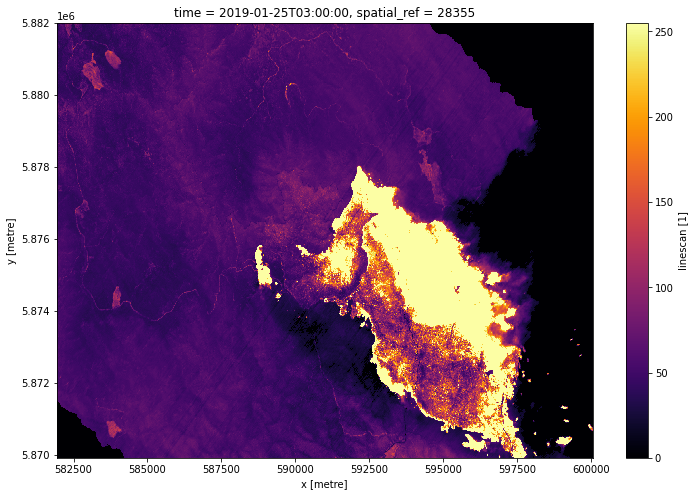

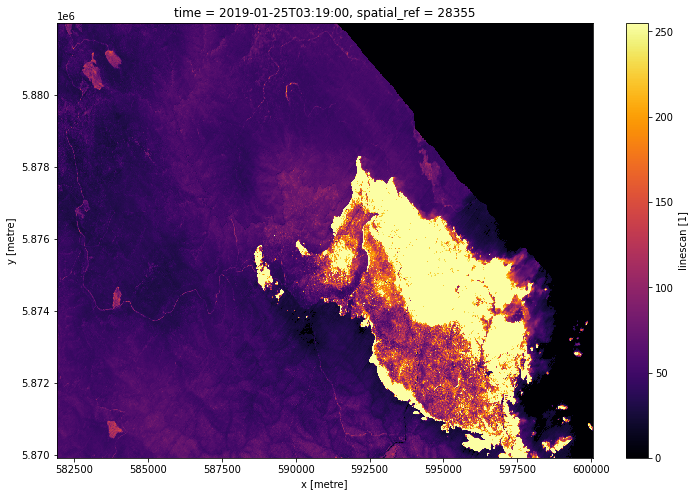

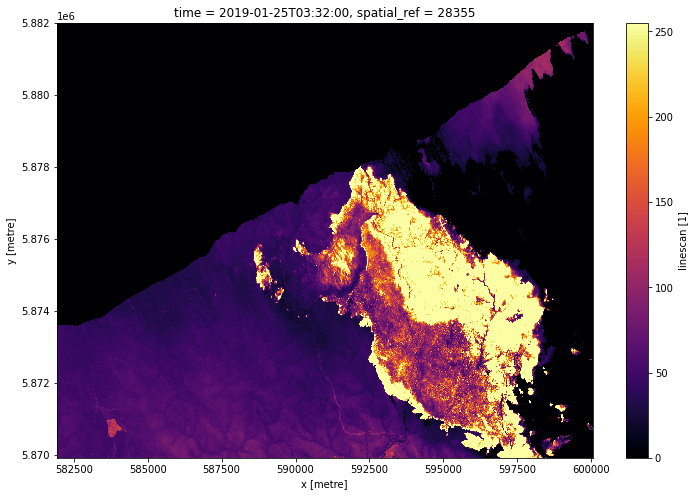

In [11]:
# let's load all the linescan imagery  in their native resolution
for target_id in target_ids:
    linescan_data = load_linescan_native(id=target_id, lat=lat, lon=lon)
    linescan_data['linescan'].squeeze().plot.imshow(cmap='inferno', robust=False, size=8)

In [12]:
# we can load it all at once, but we can only set resolution, once.
linescan = dc.load(product='linescan', 
                   time=time,
                   lat=lat,
                   lon=lon,
                   output_crs='epsg:28355',
                   resolution = resolution)


Exporting animation to animated_timeseries.gif


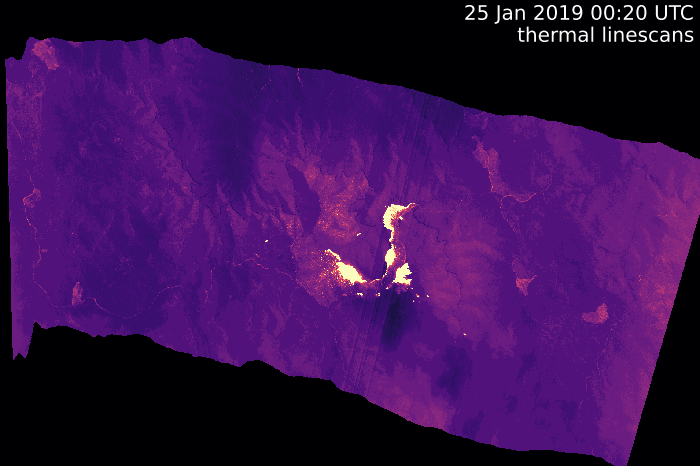

In [13]:
xr_animation(ds=linescan, output_path='animated_timeseries.gif',
                                width_pixels=700, bands=['linescan'], 
                                show_text='thermal linescans', interval=300,
                                show_date='%d %b %Y %H:%M UTC',
                                show_colorbar=False,
                                colorbar_kwargs={'cmap':'inferno', 'robust':False})


# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

## Appendix - finding Linescan images that have available Satellite imagery

Here is a simple method of finding all available Satellite images that overlap with Linescan imagery for a specific product

In [14]:
def find_matching_acquisitions(product, linescan_doc):
    """ 
    find all imagery for a product given linescan image
    """
    extent = linescan_doc['extent']
    datetime = linescan_doc['properties']['datetime']
    
    lat = (extent['lat']['begin'],extent['lat']['end'])
    lon = (extent['lon']['begin'],extent['lon']['end'])

    return dc.find_datasets(product=product,lon=lon, lat=lat, time=datetime[:10])

def find_all_matching_acquisitions(product):
    """
    find all linescan images that overlap (spatially and temporally) for a given product
    """
    linescans = dc.find_datasets(product = "linescan")
    for linescan in linescans:
        matching_acquisitions = find_matching_acquisitions(product, linescan.metadata_doc)
        if matching_acquisitions:
            print('For linescan '+ linescan.metadata_doc['id']+ ' ' + linescan.metadata_doc['label'])
            print('found '+str(len(matching_acquisitions))+' datasets')

In [15]:
find_all_matching_acquisitions('ga_s2a_ard_nbar_granule')


For linescan 33cdc07c-3a60-5490-96fb-68c4d285d22f JORDAN_235_P1_201901281204_MGA94_55
found 1 datasets
For linescan e6f2a23a-2237-597d-94c6-fac20ad17084 MACALISTER85_723_P1_201903100101_MGA94_55
found 2 datasets
For linescan 5e618539-8c85-5277-bdf1-e2eff2ca41de MACALISTER87_719_P1_201903100033_MGA94_55
found 2 datasets
For linescan 5c41fce8-07e6-5e19-9934-7bb7496d83d7 MACALISTER89_693_P1_201903091518_MGA94_55
found 4 datasets
For linescan b8803d2c-f16b-501d-9630-75d3c9e80add MACALISTER89_716_P1_201903100003_MGA94_55
found 4 datasets
For linescan 3015e5d5-3a06-5a19-baa8-f51e8a16ad03 MACALISTER89_801_P1_201903161430_MGA94_55
found 1 datasets
For linescan bcd14bfe-41b5-5215-ad73-9c1a1e5768d7 MACALISTER97_720_P1_201903100042_MGA94_55
found 2 datasets
For linescan 23a2236c-53cd-564d-a68b-fc8ed5a6bd28 MACALISTER_695_P1_201903091542_MGA94_55
found 2 datasets
For linescan 3aa512b5-5845-5175-ab81-7601ec844df7 MACALISTER_696_P1_201903091545_MGA94_55
found 2 datasets
For linescan 2255e756-c6ee-5

In [16]:
find_all_matching_acquisitions('ga_s2b_ard_nbar_granule')

For linescan 6bfce567-1fe7-5fbf-86ab-af7971988f40 MACALISTER89_773_P1_201903141329_MGA94_55
found 4 datasets
For linescan fccb6a36-e5dd-5b1c-98c4-99b9cdec83de MACALISTER89_782_P1_201903141444_MGA94_55
found 4 datasets
For linescan f4758d2c-5256-5de3-8873-54c7a86f4ef6 MACALISTER91_783_P1_201903141643_MGA94_55
found 2 datasets
For linescan a2dcfd69-f039-5201-81f2-51a5559c79a8 MACALISTER97_774_P1_201903141339_MGA94_55
found 2 datasets
For linescan 34731b49-ddb1-562f-b785-ff7a73d227bf MACALISTER97_777_P1_201903141358_MGA94_55
found 2 datasets
For linescan e9159007-bb0f-5f4e-a7e7-8905e8e07b6a MACALISTER97_778_P1_201903141405_MGA94_55
found 4 datasets
For linescan 24851ba2-74e3-523c-9723-678b8b0109d7 WALHALLA_339_P1_201902030520_MGA94_55
found 2 datasets


In [17]:
find_all_matching_acquisitions('ga_ls7e_ard_3')

For linescan 642adcbf-fd70-5bd2-b480-8450c2136848 GIPPSLAND_TRACK1_447_P1_201903011212_MGA94_55
found 1 datasets
For linescan 33cdc07c-3a60-5490-96fb-68c4d285d22f JORDAN_235_P1_201901281204_MGA94_55
found 1 datasets
For linescan 20e968bc-2238-5f66-8a0c-55a70aba1b0f WALHALLA_378_P1_201902041304_MGA94_55
found 1 datasets
For linescan aed351e2-cfa5-510e-8616-2ae1068f6ca2 WALHALLA_379_P1_201902041319_MGA94_55
found 1 datasets


In [18]:
find_all_matching_acquisitions('ga_ls8c_ard_3')

For linescan 642adcbf-fd70-5bd2-b480-8450c2136848 GIPPSLAND_TRACK1_447_P1_201903011212_MGA94_55
found 1 datasets
For linescan 33cdc07c-3a60-5490-96fb-68c4d285d22f JORDAN_235_P1_201901281204_MGA94_55
found 1 datasets
For linescan e6f2a23a-2237-597d-94c6-fac20ad17084 MACALISTER85_723_P1_201903100101_MGA94_55
found 1 datasets
For linescan 5e618539-8c85-5277-bdf1-e2eff2ca41de MACALISTER87_719_P1_201903100033_MGA94_55
found 1 datasets
For linescan 5c41fce8-07e6-5e19-9934-7bb7496d83d7 MACALISTER89_693_P1_201903091518_MGA94_55
found 1 datasets
For linescan b8803d2c-f16b-501d-9630-75d3c9e80add MACALISTER89_716_P1_201903100003_MGA94_55
found 1 datasets
For linescan bcd14bfe-41b5-5215-ad73-9c1a1e5768d7 MACALISTER97_720_P1_201903100042_MGA94_55
found 1 datasets
For linescan 23a2236c-53cd-564d-a68b-fc8ed5a6bd28 MACALISTER_695_P1_201903091542_MGA94_55
found 1 datasets
For linescan 3aa512b5-5845-5175-ab81-7601ec844df7 MACALISTER_696_P1_201903091545_MGA94_55
found 1 datasets
For linescan 2255e756-c6e